# Load data

In [1]:
%matplotlib notebook
# Load data
import sys
sys.path.append('..')
from torch import nn
import torch.nn.functional as F
import numpy as np
import torch
from utils.data import fetch_data, fetch_data_with_label, generate_data, label_to_int, divide_data

x = np.load('../data/processed/x_processed.npy')
label_seq =  ['Bolt on table', 'Bolt in jig', 'Bolt assembled']
y = label_to_int(np.load('../data/processed/y_processed.npy'), label_seq)

n_training = 5
n_val = 10
x_train, y_train, x_left, y_left = divide_data(x , y, n_training)
x_val, y_val, x_test, y_test = divide_data(x_left, y_left, n_val)

input_dim = 3 # 3d coordinates
output_dim = 3 # 3 states

x_train, y_train = torch.from_numpy(x_train).float(), torch.from_numpy(y_train.astype(int)).view(-1, 1).long()
x_val, y_val = torch.from_numpy(x_val).float(), torch.from_numpy(y_val.astype(int)).view(-1, 1).long()
x_test, y_test = torch.from_numpy(x_test).float(), torch.from_numpy(y_test.astype(int)).view(-1, 1).long()

print(y_train.shape, y_val.shape, y_test.shape)

torch.Size([15, 1]) torch.Size([30, 1]) torch.Size([90, 1])


# Note:
- CrossEntropy loss from pytorch combines softmax and NLLoss(Negative log likelihood loss). Therefore, we don't need to apply softmax at the last layer
- CrossEntropy loss from pytorch use actual class labels instead of one-hot encoding. So we are good.

In [2]:
# Define the network structure

class MyNet(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, output_dim)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x


In [3]:
def train(x_train, y_train, net, criterion):
    ind = torch.randperm(x_train.shape[0])
    x_train = x_train[ind]
    y_train = y_train[ind]
    for i in ind:
        x = x_train[i].view(-1, input_dim)
        y = y_train[i]
        net.zero_grad()
        output = net(x)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
    return loss
    

def validate(x_val, y_val, net, criterion):
    val_loss = 0
    n = x_val.shape[0]
    with torch.no_grad():
        for i in range(n):
            x = x_val[i].view(-1, input_dim)
            y = y_val[i]
            output = net(x)
            val_loss += criterion(output, y)    
        val_loss = val_loss / n
    return val_loss            

<IPython.core.display.Javascript object>


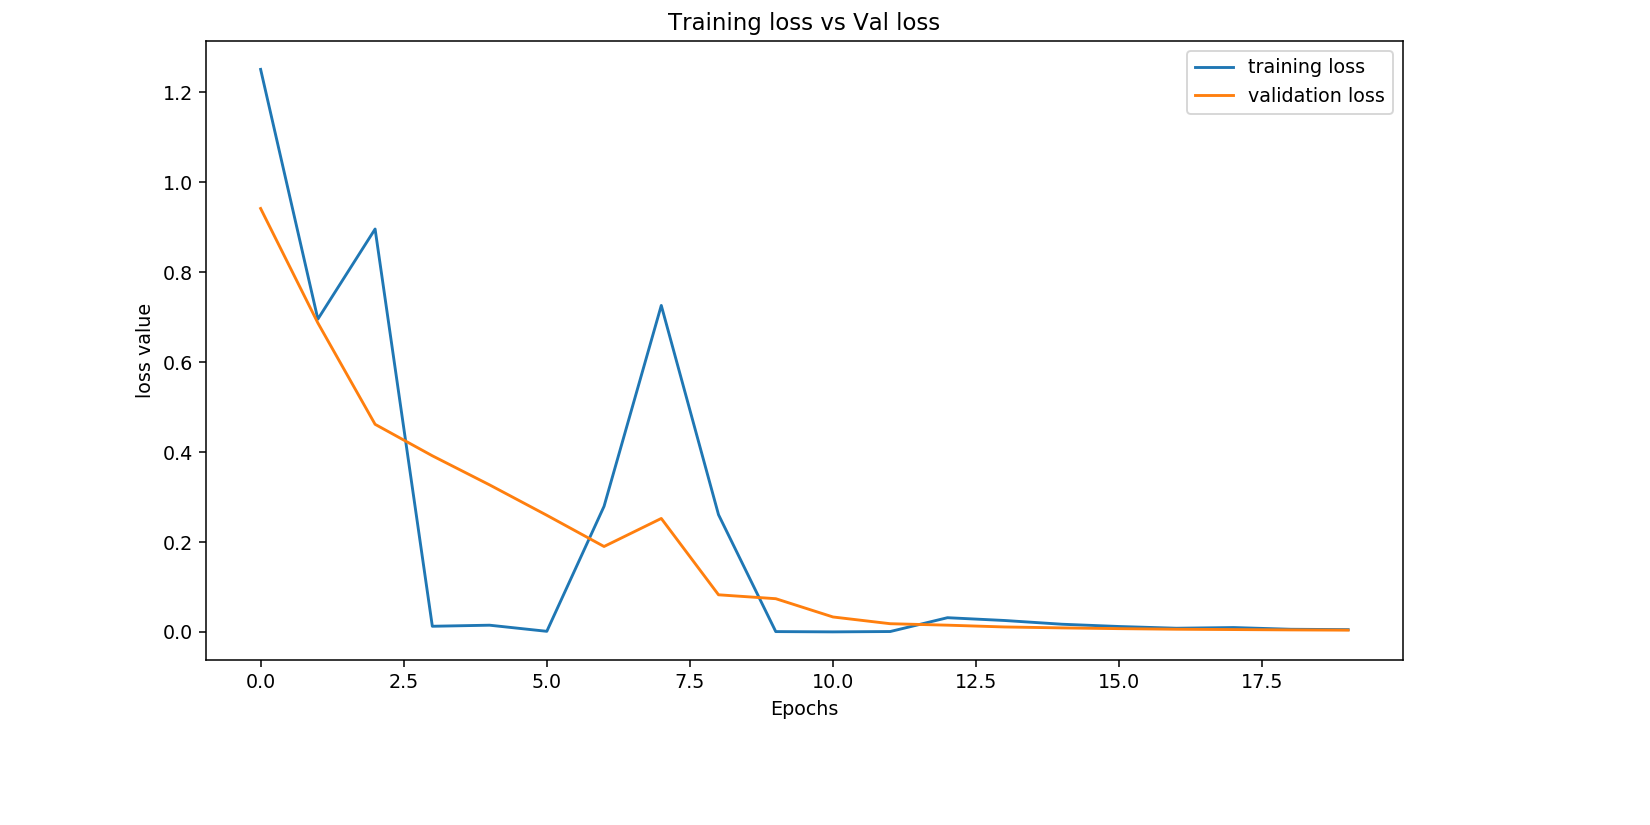

Epoch: 0 Loss: 1.2509511709213257
Epoch: 1 Loss: 0.6956301927566528
Epoch: 2 Loss: 0.8959544897079468
Epoch: 3 Loss: 0.012723223306238651
Epoch: 4 Loss: 0.015093171037733555
Epoch: 5 Loss: 0.0014965059235692024
Epoch: 6 Loss: 0.27941301465034485
Epoch: 7 Loss: 0.726061224937439
Epoch: 8 Loss: 0.26079219579696655
Epoch: 9 Loss: 0.000876757490914315
Epoch: 10 Loss: 0.0002517383254598826
Epoch: 11 Loss: 0.0010189585154876113
Epoch: 12 Loss: 0.03175802156329155
Epoch: 13 Loss: 0.025542277842760086
Epoch: 14 Loss: 0.0172489732503891
Epoch: 15 Loss: 0.01217128336429596
Epoch: 16 Loss: 0.008350221440196037
Epoch: 17 Loss: 0.009865455329418182
Epoch: 18 Loss: 0.006035791710019112
Epoch: 19 Loss: 0.005245493724942207


In [4]:
import torch.optim as optim
from matplotlib import pyplot as plt

input_dim = output_dim = 3
net = MyNet(input_dim, output_dim)
optimizer = optim.Adam(net.parameters(), lr = 0.01)
criterion = nn.CrossEntropyLoss()

epoches = 20

train_loss_list = []
val_loss_list = []

fig = plt.figure(figsize=(12,6))
plt.subplots_adjust(bottom=0.2,right=0.85,top=0.95)
ax = fig.add_subplot(1,1,1)

for e in range(epoches):
    train_loss = train(x_train, y_train, net.train(), criterion)
    train_loss_list.append(train_loss)
    val_loss = validate(x_val, y_val, net.eval(), criterion)
    val_loss_list.append(val_loss)
    ax.clear()
    ax.set_xlabel('Epochs')
    ax.set_ylabel('loss value')
    ax.set_title('Training loss vs Val loss')
    ax.plot(train_loss_list, label='training loss')
    ax.plot(val_loss_list, label='validation loss')
    ax.legend(loc='upper right')
    fig.canvas.draw()
    print("Epoch: {} Loss: {}".format(e, train_loss))

In [5]:
def predict(x, net):
    with torch.no_grad():
        output = net(x)
        return torch.argmax(output)

def test(x_test, y_test, net):
    n = x_test.shape[0]
    predictions = torch.zeros(n).long()
    with torch.no_grad():
        for i in range(n):
            prediction = predict(x_test[i,:], net)
            predictions[i] = prediction
    accuracy = int(sum(predictions == y_test.flatten())) / n 
    return predictions, accuracy

In [6]:
# import pickle

# with open('../states_model/models_bolt.pkl', 'rb') as f:
#     models_bolt = pickle.load(f)

# variance_coefficient = 5
# n_samples = 100
# samples_bolt = []
# x_test = []
# y_test = []
# for model in models_bolt:
#     x_test.append(np.random.multivariate_normal(model[0][:3] , model[1][:3,:3] * variance_coefficient , n_samples))
#     y_test += [model[2]] * n_samples 

# x_test = torch.FloatTensor(x_test).view(-1, 3)
# y_test = torch.FloatTensor(y_test)

In [7]:
predictions ,accuracy = test(x_test, y_test, net)
print(accuracy)

1.0


<IPython.core.display.Javascript object>


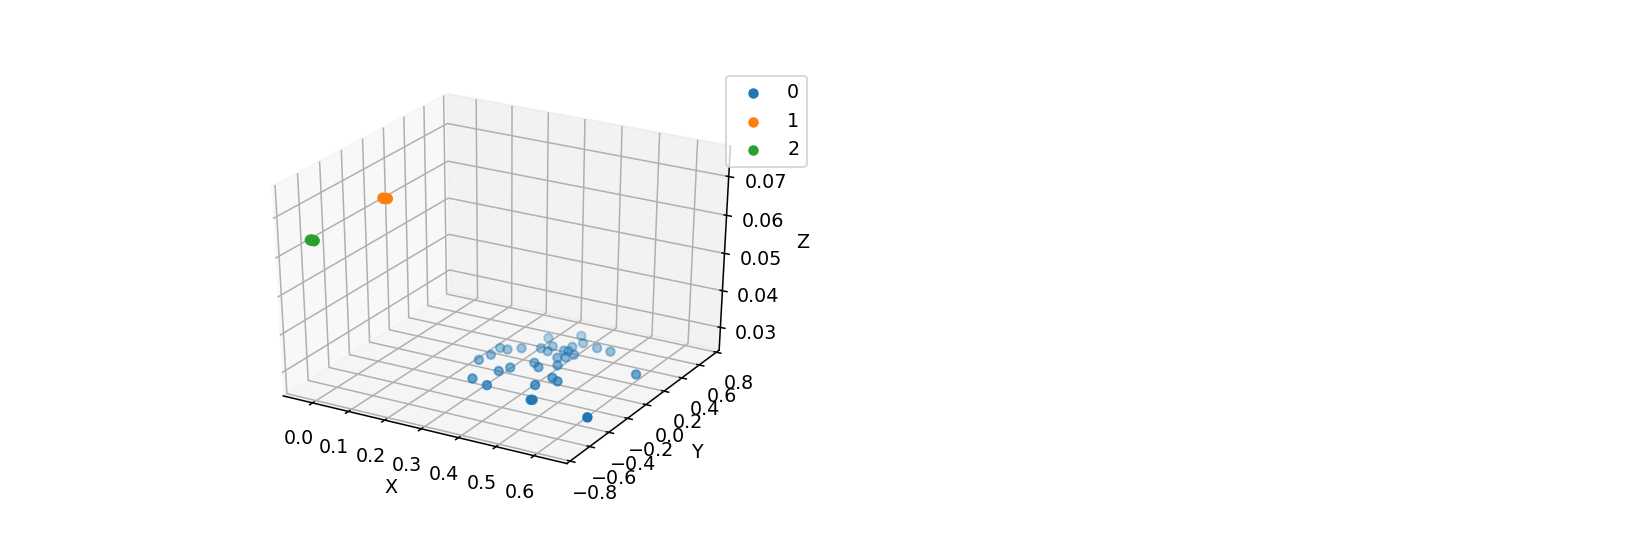

In [13]:
from utils.plotting import plot
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(2, (12,4))
ax = fig.add_subplot(1, 2, 1, projection='3d')
plot(ax, x_test, predictions.numpy())

In [12]:
set(predictions.numpy())

{0, 1, 2}

# Next step:

- Add more stages(states) to make the problem more complex to see if the network could perform well with 5 examples.